# Project: (Find the Best Markets to Advertise in)

<br>

## Questions to address:
- Check whether or not the sample we have is relevant for the study we want to perform
- Calculate how much money students spent per month and select top 4 countries
- Look at the distribution of money spent per month and remove outliers
- Find the markets with the best combination of a lot of money spent and a lot of people

<br>

## Tools:
- drop rows with NaN
  - df.dropna(axis='rows', subset=['col1'], inplace=True)
- df.groupby(['col1'])['col2'].mean()): group by col1, calculate mean of col2
- sns.boxplot
- df_1.drop(df_2.index)

<br>

### load defaults

In [37]:
import pandas as pd
import re
import numpy as np
import requests 
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))

<br>

## Dataset: New Coder Survey (information on what type of online courses new developers took)

In [5]:
df = pd.read_csv('./data/2017-fCC-New-Coders-Survey-Data.csv')
display(df.iloc[:3,:8])

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation
0,27.0,0.0,NaN,NaN,NaN,NaN,NaN,more than 1 million
1,34.0,0.0,NaN,NaN,NaN,NaN,NaN,"less than 100,000"
2,21.0,0.0,NaN,NaN,NaN,NaN,NaN,more than 1 million


<br>

## Analysis

<br>

### Q1: Check Whether the sample we have is relevant for our study

 <b>Do we have new developers interested in web development?</b>

In [9]:
df1 = df['JobRoleInterest'].value_counts().reset_index().reset_index(drop=True)
df1.columns = ['Job Title', 'Frequency']
display(df1[:9])

,Job Title,Frequency
0,Full-Stack Web Developer,823
1,Front-End Web Developer,450
2,Data Scientist,152
3,Back-End Web Developer,142
4,Mobile Developer,117
5,Game Developer,114
6,Information Security,92
7,"Full-Stack Web Developer, Front-End Web Deve...",64
8,"Front-End Web Developer, Full-Stack Web Deve...",56


- Yes, a lot of them took web related courses

<b>Are people interested in only one subject or they can be interested in more than one subject?</b>

In [10]:
print('Total answers=%d, Total people=%d' % (sum(df1['Frequency']),len(df['JobRoleInterest'])))

Total answers=6992, Total people=18175


- most people must have only one subject since we only have 6000 answers to subject for 18000 people

<b>How many people are interested in at least one of the two subjects we teach (web and mobile development)?</b>

In [16]:
number_of_web = 0
for index, row in df1.iterrows():    
    if 'Web' in row['Job Title']:
        number_of_web+=row['Frequency']
          
print("People interested in web: %0.1f%%" % (100.*int(number_of_web)/len(df['JobRoleInterest'])))  

number_of_web = 0
for index, row in df1.iterrows():    
    if 'Mobile' in row['Job Title']:
        number_of_web+=row['Frequency']
          
print("People interested in mobile: %0.1f%%" % (100.*int(number_of_web)/len(df['JobRoleInterest'])))  

People interested in web: 31.8%
People interested in mobile: 12.7%


<br>

### Q2: Drop rows whithout interest specified and plot country distribution frequency

In [17]:
df.dropna(axis='rows', subset=['JobRoleInterest'], inplace=True)
print('Total people=%d' % len(df['JobRoleInterest']))

df1 = df['CountryLive'].value_counts().reset_index().reset_index(drop=True)
df1.columns = ['CountryLive', 'Frequency']
print (df1[:5])

Total people=6992
                CountryLive  Frequency
0  United States of America       3125
1                     India        528
2            United Kingdom        315
3                    Canada        260
4                    Poland        131


<br>

### Q3: Narrow down analysis to top 4 countries and compute money spent per month

In [34]:
country_list=['United States of America', 'India', 'United Kingdom', 'Canada']
final_df = df.loc[df['CountryLive'].isin(country_list)].copy()

display(final_df[['Age','CountryLive']].iloc[:3])

,Age,CountryLive
1,34.0,United States of America
2,21.0,United States of America
6,29.0,United Kingdom


In [36]:
#compute money per month
final_df['MonthsProgramming'].replace(0,1, inplace = True)
final_df['MoneyPerMonth'] = final_df['MoneyForLearning']/final_df['MonthsProgramming']

#drop null values
final_df = final_df[final_df['JobRoleInterest'].notnull()].copy()
final_df = final_df[final_df['MoneyPerMonth'].notnull()]
final_df = final_df[final_df['CountryLive'].notnull()]
print('Number of students willing to pay: %d' % len(final_df))

#group by country and calculate mean of money spent per month
print(final_df.groupby(['CountryLive'])['MoneyPerMonth'].mean())

Number of students willing to pay: 3915
CountryLive
Canada                      113.510961
India                       135.100982
United Kingdom               45.534443
United States of America    227.997996
Name: MoneyPerMonth, dtype: float64


- The mean amount of money spent seems to vary a lot between countries so we need to investigate further what is causing the variation

<br>

### Q4: Generate box plots to visualize distributions of money spent per month in the top 4 countries

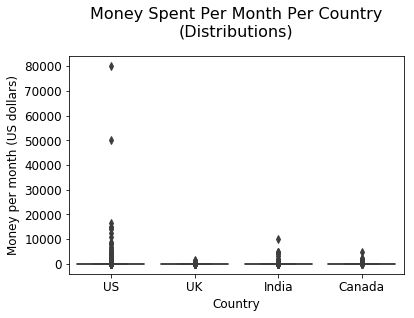

In [39]:
sns.boxplot(y = 'MoneyPerMonth', x = 'CountryLive',data = final_df)
plt.title('Money Spent Per Month Per Country\n(Distributions)',fontsize = 16)
plt.ylabel('Money per month (US dollars)')
plt.xlabel('Country')
plt.xticks(range(4), ['US', 'UK', 'India', 'Canada']) # avoids tick labels overlap
plt.show()

- There are a lot of outliers in the distributions, particulary in the US and India, the countries with the highest means

<br>

### Q5: Remove outliers (broad condition)

In [40]:
# Isolate only those participants who spend less than 10000 per month
final_df = final_df[final_df['MoneyPerMonth'] < 20000]
print(final_df.groupby(['CountryLive'])['MoneyPerMonth'].mean())

CountryLive
Canada                      113.510961
India                       135.100982
United Kingdom               45.534443
United States of America    183.800110
Name: MoneyPerMonth, dtype: float64


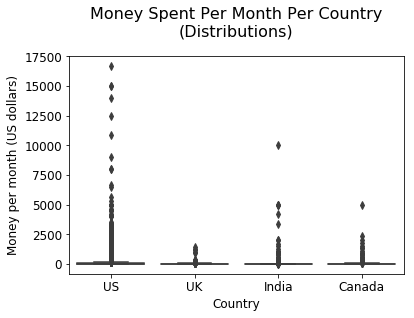

In [41]:
sns.boxplot(y = 'MoneyPerMonth', x = 'CountryLive',data = final_df)
plt.title('Money Spent Per Month Per Country\n(Distributions)',fontsize = 16)
plt.ylabel('Money per month (US dollars)')
plt.xlabel('Country')
plt.xticks(range(4), ['US', 'UK', 'India', 'Canada']) # avoids tick labels overlap
plt.show()

<br>

### Q6: Remove outliers (detailed level per country)

<b>Remove India's outliers:</b> MoneyPerMonth >= 2500

In [42]:
india_outliers = final_df[(final_df['CountryLive'] == 'India') & (final_df['MoneyPerMonth'] >= 2500)]
final_df = final_df.drop(india_outliers.index) # using the row labels

<b>Remove Canada's outliers:</b> MoneyPerMonth >= 4500

In [43]:
canada_outliers = final_df[(final_df['CountryLive'] == 'Canada') & (final_df['MoneyPerMonth'] > 4500)]
# Remove the extreme outliers for Canada
final_df = final_df.drop(canada_outliers.index)

<b>Remove US's outliers:</b> No Bootcamp and less than 3 months programming (one of buyers)

In [44]:
us_outliers = final_df[(final_df['CountryLive'] == 'United States of America') & (final_df['MoneyPerMonth'] >= 6000)]
#remove: Didn't attend bootcamps, less than 3 months programming
no_bootcamp = final_df[(final_df['CountryLive'] == 'United States of America') & 
                       (final_df['MoneyPerMonth'] >= 6000) &
                       (final_df['AttendedBootcamp'] == 0) ]

final_df = final_df.drop(no_bootcamp.index)


# Remove the respondents that had been programming for less than 3 months
less_than_3_months = final_df[(final_df['CountryLive'] == 'United States of America') & 
                              (final_df['MoneyPerMonth'] >= 6000) &
                              (final_df['MonthsProgramming'] <= 3) ]

final_df = final_df.drop(less_than_3_months.index)

<br>

### Q7: Best Market to advertise after removing outliers?

In [51]:
money_spent = final_df.groupby(['CountryLive'])['MoneyPerMonth'].mean()
population = final_df['CountryLive'].value_counts(normalize = True) * 100

In [52]:
print(money_spent)

CountryLive
Canada                       93.065400
India                        65.758763
United Kingdom               45.534443
United States of America    142.654608
Name: MoneyPerMonth, dtype: float64


In [53]:
print(population)

United States of America    74.967908
India                       11.732991
United Kingdom               7.163030
Canada                       6.136072
Name: CountryLive, dtype: float64


In [54]:
print(population*money_spent)

Canada                        571.055986
India                         771.546974
United Kingdom                326.164561
United States of America    10694.517462
dtype: float64


- US is clearly the best choice to advertise on
- India is the second choice, less money per person, but more people